We start with the data from 2023 and 2025, because we saw a big change in the political field between those two elections. For now as a simplification we will divide the parties into three groups:
- Left: GL_PvdA, SP, PvdD, Volt, DENK, BIJ1, CU
- Centre: NSC, VVD, D66, 50Plus
- Right: FvD, JA21, BVNL, PVV, BBB, SGP

#### Vote share
Luckily for us the vote share is known for each of the years and does not need to be calculated manually.

(The gap between BIJ 1, which is the party with the lowest amount of votes and the next party is a factor of 4. So BIJ1 is the cutoff point. The remaining parties not included here have a total of 0.4% of the total votes)

In [29]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [30]:
parties2023 = {
    'GL_PvdA': 0.1575, 'SP': 0.0315, 'PvdD': 0.0225,
    'Volt': 0.0171, 'DENK': 0.0237, 'BIJ1': 0.0042,
    'CU': 0.0204, 'NSC': 0.1288, 'VVD': 0.1524,
    'D66': 0.0629, '50Plus': 0.0049, 'FvD': 0.0223,
    'JA21': 0.0068, 'BVNL': 0.0051, 'PVV': 0.2349,
    'BBB': 0.0465, 'SGP': 0.0208
}

# Create left,right, centre list
left_keys = ['GL_PvdA', 'SP', 'PvdD', 'Volt', 'DENK', 'BIJ1', 'CU']
centre_keys = ['NSC', 'VVD', 'D66', '50Plus']
right_keys = ['FvD', 'JA21', 'BVNL', 'PVV', 'BBB', 'SGP']

In [31]:
def dict_to_party_arrays(party_share_dict):
    # Extract the parties from the list
    # Convert into a numpy array
    # Normalize probabilities so that all probabilities sum to 1
    parties = list(party_share_dict.keys())
    probs = np.array([party_share_dict[p] for p in parties], dtype=float)
    probs /= probs.sum()

    # Create mapping
    # Party to index and index to party
    p2i = {p: i for i, p in enumerate(parties)}
    i2p = {i: p for p, i in p2i.items()}
    return parties, probs, p2i, i2p

party_order = left_keys + centre_keys + right_keys
parties, probs_2023, p2i, i2p = dict_to_party_arrays(parties2023)

### ABM

Watts Strogatz documentation
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html
- https://www.geeksforgeeks.org/python/small-world-model-using-python-networkx/

Scale Free documentation
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html
- https://www.geeksforgeeks.org/dsa/barabasi-albert-graph-scale-free-models/

Random Graph documentation:
- https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph
- https://www.geeksforgeeks.org/dsa/erdos-renyl-model-generating-random-graphs/

In [32]:
"""
Create a function that creates different types of graphs.
N: Number of voters (agents) in the model.
graph type: different types of graphs to generate: 'small-world', 'scale-free','random'.
seed: random seed for reproducibility.
**kwargs: extra parameters depending on the graph tupe.
Returns: The respective generated graph type.
Note: for now, graph parameters are abitrary.
"""
def build_graph(N, graph_type ='small_world', seed = 0, **kwargs):
    #k: number of neighbors.
    #p: rewire probability.
    if graph_type =='small_world':
        k = kwargs.get('k', 10)
        p = kwargs.get('p', 0.05)
        return nx.watts_strogatz_graph(N,k,p, seed=seed)

    #m: edges to attach per new node.
    if graph_type == 'scale_free':
        m = kwargs.get('m', 5)
        return nx.barabasi_albert_graph(N,m , seed=seed)

    #p: edge probability.
    if graph_type =='random':
        p = kwargs.get('p', 0.002)
        return nx.erdos_renyi_graph(N,p,seed=seed)

In [33]:
"""
Converts a (networkx) graph into an adjacency list.
adj[i]: numpy array of the neighbors of node i.
G: graph with nodes 0....N-1.
adj: list of neighbors.
"""
def adjacency_list(G):
    # total number of voters
    # create empty array
    N = G.number_of_nodes()
    adj = [None] * N

    # Convert neighbors of i into an array of integers
    for i in range(N):
        adj[i] = np.fromiter(G.neighbors(i), dtype=int)
    return adj



In [34]:
"""
Initialize the voter population.
Each voter i has:
- party[i]
-L[i]: loyalty between [0,1] probability that the voter refuses to chose a new party.
-S[i]: susceptibility between [0,1], strength of social influence.
-B[i]: political bias between [-1,1] where -1 is left-wing and 1 is right-wing
N: number of voters.
probs: party probabilities based on the election results of year 2xxx.
L_range: range of which loyalty is drawn from.
S-range: range of which susceptibility is drawn from.
B-range: range of which bias is drawn from

seed: random seed for reproducibility.
party: party assignment for each voter.
L: loyalty value per voter.
S: susceptibility per voter.
B: bias per voter
"""
def init_agents(N, probs, L_range=(0.7, 0.95), S_range=(0.3, 1.0), B_range=(-1, 1), seed=0):
    rng = np.random.default_rng(seed)
    P = len(probs)

    # Assign parties to voters based on the 2023 vote share
    # Assign both loyalty and susceptibility
    party = rng.choice(P, size=N, p=probs)
    L = rng.uniform(L_range[0], L_range[1], size=N)
    S = rng.uniform(S_range[0], S_range[1], size=N)
    
    # Assign political bias to each voter
    B = rng.uniform(B_range[0], B_range[1], size=N)
    
    return party, L, S, B


In [35]:
"""
Build matrix A where A[t,p]: attractiveness of party p at time t.
Attractiveness tries to capture shocks like: new party arrival, a scandal, media boost, etc.
Baseline A =1.
parties: party names.
T: number of time steps.
events: a dictionary of events. 
eg. {'party':NSC, 'start':5,'end':20, 'A':2.5}
A: attractiveness over time.
"""
def attractiveness_tracker(parties, T, events = None):
    # Set the initial attractiveness to 1
    # Float since the attracteveness can be a decimal number
    P = len(parties)
    A = np.ones((T, P), dtype=float)

    if events:
        # map party name to index
        name2idx = {p: i for i, p in enumerate(parties)}

        # Find the party which is effected by the events
        # Update the A for the time window
        for ev in events:
            idx = name2idx[ev["party"]]
            A[ev["start"]:ev["end"], idx] = float(ev["A"])

    return A


In [36]:
"""
Compute fi(t): the fraction of voter i's neighbors supporting party p.
party: party[j] gives the party of neighbor j.
neighbors: neighbor indices of agent i.
P; number of parties.
f: fraction of neighbors in each party.
"""
def neighbor_fraction_party(party, neighbors, num_parties):
    # find the amount of neighbors
    degree = len(neighbors)

    # special case if degree == 0
    # voter has no neighbors so environment has no influence on this votes
    if degree == 0:
        return np.ones(num_parties) / num_parties

    # get the party label of the neighbors
    # count how many neighbors belong to each party
    # return the normalized probability so that it sums to 1
    neigh_parties = party[neighbors]
    counts = np.bincount(neigh_parties, minlength=num_parties).astype(float)
    return counts/ counts.sum()



In [37]:
"""
Compute the choice probability of a voter based on:
-f: neighbor party fractions for voter i.
- S_i: susceptibility
- beta: strength of peer pressure.
- gamma: strength of external events.
- delta: strength of bias
- A_t: attractiveness.
- bias: bias
score(i,p): = max(0, exp(beta*S_i*f_p) * A_p^gamma + delta * bias)
P_i(p): score_(i,p)/sum_q * score_(i,q).
scores: probability distribution across parties (normalized so that is sums to 1).
"""
def compute_probs(
        neighbor_fraction, susceptibility,
        peer_pressure_strength, events_strength, bias_strength, attractiveness, bias
    ):
    # compute scores and normalizee
    scores = np.exp(
        peer_pressure_strength * susceptibility * neighbor_fraction
        + events_strength * np.log(attractiveness)
    )
    
    scores += bias_strength * bias
    scores = np.maximum(scores, 0)
    
    if scores.sum() == 0:
        scores += 0.000001
    scores /= scores.sum()

    return scores


In [38]:
"""
We must create a function that updates voter i.
First we must check the loyalty value.
Then we compute fi(t) from the neighbors.
Compute Pi(p) from f and A(t)
Sample a new party from Pi(p)
"""
def update_voter(
        voter_index, party, loyalty, susceptibility, neighbors,
        peer_pressure_strength, events_strength, bias_strength, attractiveness, bias, rng
    ):
    # voter keeps the same party if rng is smaller than loyalty
    if rng.random() < loyalty[voter_index]:
        return

    # compute f
    num_parties = len(attractiveness)
    neighbor_votes = neighbor_fraction_party(
        party, neighbors[voter_index], num_parties
    )

    #Compute Pi(p)
    probs = compute_probs(
        neighbor_votes, susceptibility[voter_index],
        peer_pressure_strength, events_strength, bias_strength, attractiveness, bias[voter_index]
    )

    #Sample new party
    party[voter_index] = rng.choice(num_parties, p=probs)


In [39]:
"""
Run the ABM and record vote shares.
N: Number of voters.
parties: party names, lenghts P.
probs_2023: initial vote probabilities based on the 2023 election results.
T: number of time steps (months for now).
microsteps_per_t: number of times a voter is updated per time step. Default = N.
beta, gamma: model parameters controlling social and event strength.
L_range, S_range: loyalty and susceptibility ranges.
graph_type: type of graph.
graph_kwargs: parameters for the chosen graph.
events: definition of a attractiveness event.
seed: ranomd seed for reproducibility.
history: array with shape (T+1, P). 
history[t,p]= vote share of party p at time t.
"""
def simulate_amb(
        N, parties, probs_2023, T= 24, beta = 3.0,
        gamma =1.0, delta=1.0, L_range=(0.7,0.95), S_range=(0.3,1.0), B_range=(-1, 1),
        graph_type="small_world",microsteps_per_t=None, graph_kwargs =None,
        events =None, seed = 0
        ):
    #set the default graph type to small world
    if graph_kwargs is None:
        graph_kwargs ={"k": 10, "p":0.05}

    # Updates per time step
    # default = N
    # can be used to scale down from month to week for example
    if microsteps_per_t is None:
        microsteps_per_t = N

    rng = np.random.default_rng(seed)
    P = len(parties)

    # initialize voters using 2023 data
    party, L, S, B = init_agents(
        N, probs_2023,
        L_range=L_range,
        S_range=S_range,
        B_range=B_range,
        seed = seed
    )

    # create graph + adjencey list
    G = build_graph(N, graph_type=graph_type, seed=seed, **graph_kwargs)
    adj = adjacency_list(G)

    # create the attractiveness 
    A = attractiveness_tracker(parties, T, events=events)

    # create array to store party shares
    history = np.zeros((T + 1, P),dtype=float)

    # t = 0
    for i in range(N):
        history[0, party[i]] += 1 / N

    for t in range(T):
        # For each microstep, update N voters
        for _ in range(microsteps_per_t):
            voter_index = rng.integers(0, N)  # Randomly pick a voter to update
            update_voter(
                voter_index, party, L, S, adj, beta, gamma, delta, A[t], B, rng
            )

        # Record the vote share at time step t
        for i in range(N):
            history[t + 1, party[i]] += 1 / N

    return history

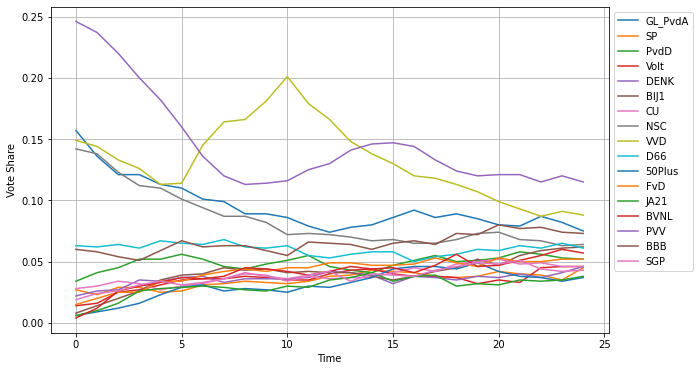

In [40]:
events = [
    {"party": "VVD", "start": 5, "end": 10, "A": 2.0},
    {"party": "PVV", "start": 8, "end": 15, "A": 1.5}
]

parties2023_normalized = list(parties2023.values()) / np.sum(list(parties2023.values()))

T = 24

history = simulate_amb(
    N=1000, 
    parties=list(parties2023.keys()),
    probs_2023=parties2023_normalized,
    T=T, 
    beta=3, 
    gamma=1, 
    delta=1.5,
    B_range=(-1,1), 
    graph_type="small_world",
    events=events, 
    seed=1
)

plt.figure(figsize=(10, 6))
for i, party in enumerate(parties2023.keys()):
    plt.plot(range(T + 1), history[:, i], label=party)

plt.xlabel('Time')
plt.ylabel('Vote Share')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()





### Todo-list
- create simulation function
- recording/ storing function
- Plotting
- Grouping function (left,right,centre)
